# Standard U-Net: Baseline Model for Tumor Segmentation + Classification

This notebook implements a **single, standard U-Net** with dual outputs (segmentation + classification) as a baseline to compare against Co-DeepNet.

## Goal: Prove Co-DeepNet's Superiority

According to the research paper, **two smaller cooperative networks should outperform one larger network**:
- Better accuracy with less computational cost
- More efficient exploration of solution space
- Better generalization through network diversity

This baseline will help us verify these claims!

## Architecture Overview:
```
Input → [Single U-Net] → {Classification, Segmentation}
```

vs Co-DeepNet:
```
Input → [U-Net-A] ⟷ Knowledge Transfer ⟷ [U-Net-B] → Ensemble → {Classification, Segmentation}
```

## 1. Setup & Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from typing import Tuple, Dict, List
from PIL import Image

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.7.1+cu118


## 2. Standard U-Net Architecture with Dual Output

Same architecture as Co-DeepNet's individual networks, but trained as a single model.

In [2]:
class DoubleConv(nn.Module):
    """(Conv2d → BatchNorm → ReLU) × 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class SegmentationUNet(nn.Module):
    """
    Standard U-Net for SEGMENTATION ONLY.
    Classification is derived from the segmentation mask.
    """
    def __init__(self, in_channels=1, seg_classes=1):
        super().__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck
        self.bottleneck = DoubleConv(512, 1024)
        
        # Decoder (Expanding Path)
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        
        # Segmentation
        self.seg_out = nn.Conv2d(64, seg_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.dec4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.dec3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.dec2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.dec1(dec1)
        
        # Segmentation Output
        seg_logits = self.seg_out(dec1)
        
        return seg_logits
    
    def count_parameters(self):
        """Count total trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


# Initialize model
unet_model = SegmentationUNet(in_channels=1, seg_classes=1).to(device)
num_params = unet_model.count_parameters()

print(f"\n✓ Segmentation-Only U-Net initialized")
print(f"  Total parameters: {num_params:,}")
print(f"  Model size: ~{num_params * 4 / 1024 / 1024:.2f} MB (fp32)")
print(f"  Architecture: Segmentation")


✓ Segmentation-Only U-Net initialized
  Total parameters: 31,042,369
  Model size: ~118.42 MB (fp32)
  Architecture: Segmentation


## 3. Dataset Loading (Pre-Split)

Loading pre-split train/val/test data from EDA.ipynb preprocessing.

In [3]:
class PreSplitTumorDataset(Dataset):
    """Dataset for loading pre-split train/val/test data"""
    def __init__(self, data_dir: str, split='train'):
        """
        Args:
            data_dir: Path to preprocessed_data directory
            split: 'train', 'val', or 'test'
        """
        self.data_dir = Path(data_dir) / split
        self.split = split
        
        print(f"\n{'='*70}")
        print(f"📂 Loading {split.upper()} dataset from: {self.data_dir}")
        print(f"{'='*70}")
        
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.data_dir}")
        
        self.samples = []
        
        control_dir = self.data_dir / 'controls' / 'imgs'
        patient_img_dir = self.data_dir / 'patients' / 'imgs'
        patient_label_dir = self.data_dir / 'patients' / 'labels'
        
        print(f"  Controls dir: {control_dir.exists()}")
        print(f"  Patients dir: {patient_img_dir.exists()}")
        print(f"  Labels dir: {patient_label_dir.exists()}")
        
        if control_dir.exists():
            control_files = sorted(list(control_dir.glob('*.png')))
            print(f"\n  Found {len(control_files)} control images")
            for img_path in control_files:
                self.samples.append((img_path, None, 0))
        
        if patient_img_dir.exists() and patient_label_dir.exists():
            patient_files = sorted(list(patient_img_dir.glob('*.png')))
            print(f"  Found {len(patient_files)} patient images")
            
            matched = 0
            for img_path in patient_files:
                img_stem = img_path.stem
                
                possible_label_names = [
                    img_path.name,
                    img_stem + '.png',
                    img_stem.replace('patient_', 'segmentation_') + '.png',
                ]
                
                label_path = None
                for label_name in possible_label_names:
                    test_path = patient_label_dir / label_name
                    if test_path.exists():
                        label_path = test_path
                        break
                
                if label_path:
                    self.samples.append((img_path, label_path, 1))
                    matched += 1
            
            print(f"  Matched {matched} patient images with labels")
        
        num_controls = len([s for s in self.samples if s[2] == 0])
        num_patients = len([s for s in self.samples if s[2] == 1])
        
        print(f"\n{'='*70}")
        print(f"📊 {split.upper()} SET SUMMARY")
        print(f"{'='*70}")
        print(f"  Controls: {num_controls}")
        print(f"  Patients: {num_patients}")
        print(f"  Total: {len(self.samples)}")
        print(f"  Tumor ratio: {num_patients/len(self.samples)*100:.1f}%")
        print(f"{'='*70}\n")
        
        if len(self.samples) == 0:
            raise ValueError(f"No samples found in {self.data_dir}")
    
    def __len__(self):
        return len(self.samples)
    
    def _load_image(self, path: Path) -> np.ndarray:
        """Load PNG image and convert to grayscale numpy array"""
        img = Image.open(path).convert('L')
        return np.array(img)
    
    def __getitem__(self, idx):
        img_path, label_path, has_tumor = self.samples[idx]
        
        image = self._load_image(img_path)
        
        if image.max() > 1.0:
            image = image / 255.0
        
        if label_path and label_path.exists():
            mask = self._load_image(label_path)
            if mask.max() > 1.0:
                mask = mask / 255.0
        else:
            mask = np.zeros_like(image)
        
        if image.ndim == 2:
            image = image[np.newaxis, ...]
        if mask.ndim == 2:
            mask = mask[np.newaxis, ...]
        
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        clf_label = torch.tensor(has_tumor, dtype=torch.long)
        
        return image, mask, clf_label


print("="*70)
print("🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET")
print("="*70)

possible_paths = [
    Path('/Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data'),
    Path('/work/IdaHayJørgensen#9284/Notebooks/preprocessed_data'),
]

DATA_DIR = None
for path in possible_paths:
    print(f"\n🔍 Checking: {path}")
    if path.exists():
        has_train = (path / 'train').exists()
        has_val = (path / 'val').exists()
        has_test = (path / 'test').exists()
        
        print(f"   Train folder: {has_train}")
        print(f"   Val folder: {has_val}")
        print(f"   Test folder: {has_test}")
        
        if has_train and has_val and has_test:
            DATA_DIR = path
            print(f"   ✅ Using this directory!")
            break
    else:
        print(f"   ❌ Directory doesn't exist")

if DATA_DIR is None:
    raise FileNotFoundError("Pre-split data directory not found! Please run EDA.ipynb first to create splits.")

print(f"\n{'='*70}")
print(f"📂 Final data directory: {DATA_DIR}")
print(f"{'='*70}\n")

train_dataset = PreSplitTumorDataset(str(DATA_DIR), split='train')
val_dataset = PreSplitTumorDataset(str(DATA_DIR), split='val')
test_dataset = PreSplitTumorDataset(str(DATA_DIR), split='test')

BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n{'='*70}")
print(f"✅ DATALOADERS CREATED")
print(f"{'='*70}")
print(f"  Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"  Val batches: {len(val_loader)} ({len(val_dataset)} samples)")
print(f"  Test batches: {len(test_loader)} ({len(test_dataset)} samples)")
print(f"{'='*70}\n")


🔍 LOADING PRE-SPLIT MIP-PET TUMOR DATASET

🔍 Checking: /Users/idahayjorgensen/Documents/cs/deep_learning/DeepLearning-MiniProject/preprocessed_data
   ❌ Directory doesn't exist

🔍 Checking: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data
   Train folder: True
   Val folder: True
   Test folder: True
   ✅ Using this directory!

📂 Final data directory: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data


📂 Loading TRAIN dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/train
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 298 control images
  Found 127 patient images
  Matched 127 patient images with labels

📊 TRAIN SET SUMMARY
  Controls: 298
  Patients: 127
  Total: 425
  Tumor ratio: 29.9%


📂 Loading VAL dataset from: /work/IdaHayJørgensen#9284/Notebooks/preprocessed_data/val
  Controls dir: True
  Patients dir: True
  Labels dir: True

  Found 64 control images
  Found 27 patient images
  Matched 27 patient images with labels

📊 VA

## 4. Training Setup

In [4]:
# Training configuration
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Optimizer
optimizer = torch.optim.Adam(unet_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# Loss function: BCE for segmentation
seg_criterion = nn.BCEWithLogitsLoss()

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'epoch_times': []
}

print("✓ Training configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Loss: BCE (Binary Cross-Entropy)")
print(f"  Metrics: Dice, IoU, BCE")
print(f"  Optimizer: Adam with weight decay={1e-5}")

✓ Training configuration:
  Epochs: 50
  Learning rate: 0.0001
  Loss: BCE (Binary Cross-Entropy)
  Metrics: Dice, IoU, BCE
  Optimizer: Adam with weight decay=1e-05


## Training Loop with Validation

In [5]:
import time

def dice_coefficient(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute Dice coefficient"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum()
    
    dice = (2.0 * intersection) / (union + epsilon)
    return dice.item()


def iou_score(pred, target, threshold=0.5, epsilon=1e-7):
    """Compute IoU (Intersection over Union)"""
    pred_binary = (pred > threshold).float()
    target_binary = (target > threshold).float()
    
    intersection = (pred_binary * target_binary).sum()
    union = pred_binary.sum() + target_binary.sum() - intersection
    
    iou = intersection / (union + epsilon)
    return iou.item()


def train_epoch(model, dataloader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Train]")
    for images, masks, _ in pbar:
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        seg_logits = model(images)
        
        # Compute loss
        loss = seg_criterion(seg_logits, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Compute metrics
        seg_probs = torch.sigmoid(seg_logits)
        dice = dice_coefficient(seg_probs, masks)
        iou = iou_score(seg_probs, masks)
        
        # Track metrics
        epoch_loss.append(loss.item())
        epoch_dice.append(dice)
        epoch_iou.append(iou)
        
        # Update progress
        pbar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'dice': f"{dice:.4f}",
            'iou': f"{iou:.4f}"
        })
    
    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


def validate_epoch(model, dataloader, epoch):
    """Validate for one epoch"""
    model.eval()
    epoch_loss = []
    epoch_dice = []
    epoch_iou = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Epoch {epoch} [Val]")
        for images, masks, _ in pbar:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            seg_logits = model(images)
            loss = seg_criterion(seg_logits, masks)
            
            # Compute metrics
            seg_probs = torch.sigmoid(seg_logits)
            dice = dice_coefficient(seg_probs, masks)
            iou = iou_score(seg_probs, masks)
            
            # Track metrics
            epoch_loss.append(loss.item())
            epoch_dice.append(dice)
            epoch_iou.append(iou)
            
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'dice': f"{dice:.4f}",
                'iou': f"{iou:.4f}"
            })
    
    return {
        'loss': np.mean(epoch_loss),
        'dice': np.mean(epoch_dice),
        'iou': np.mean(epoch_iou)
    }


print("\n" + "="*70)
print("🚀 STARTING TRAINING (Segmentation-Only U-Net)")
print("="*70)
print("Stage 1: Segmentation Training")
print("Stage 2: Classification from Masks\n")

training_start = time.time()
best_val_dice = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start = time.time()
    
    # Train
    train_metrics = train_epoch(unet_model, train_loader, optimizer, epoch)
    
    # Validate
    val_metrics = validate_epoch(unet_model, val_loader, epoch)
    
    # Track history
    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])
    
    epoch_time = time.time() - epoch_start
    history['epoch_times'].append(epoch_time)
    
    # Print summary
    print(f"\nEpoch {epoch}/{NUM_EPOCHS} Summary:")
    print(f"  Train - Loss: {train_metrics['loss']:.4f}, Dice: {train_metrics['dice']:.4f}, IoU: {train_metrics['iou']:.4f}")
    print(f"  Val   - Loss: {val_metrics['loss']:.4f}, Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Time: {epoch_time:.1f}s")
    
    # Save best model
    if val_metrics['dice'] > best_val_dice:
        best_val_dice = val_metrics['dice']
        torch.save(unet_model.state_dict(), 'best_unet_segmentation.pth')
        print(f"  ✓ New best model saved! (Dice: {best_val_dice:.4f})")

training_time = time.time() - training_start

print("\n" + "="*70)
print("🎓 SEGMENTATION TRAINING COMPLETE!")
print("="*70)
print(f"Total training time: {training_time:.1f}s ({training_time/60:.1f} minutes)")
print(f"Average epoch time: {np.mean(history['epoch_times']):.1f}s")
print(f"Best validation Dice: {best_val_dice:.4f}")

# Load best model
unet_model.load_state_dict(torch.load('best_unet_segmentation.pth'))
print("\n✓ Best model loaded for evaluation!")


🚀 STARTING TRAINING (Segmentation-Only U-Net)
Stage 1: Segmentation Training
Stage 2: Classification from Masks



Epoch 1 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.52it/s, loss=0.6309, dice=0.0885, iou=0.0463]



Epoch 1/50 Summary:
  Train - Loss: 0.5265, Dice: 0.0368, IoU: 0.0194
  Val   - Loss: 0.6425, Dice: 0.0337, IoU: 0.0178
  Time: 14.4s
  ✓ New best model saved! (Dice: 0.0337)


Epoch 2 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.32it/s, loss=0.6693, dice=0.1307, iou=0.0699]



Epoch 2/50 Summary:
  Train - Loss: 0.3854, Dice: 0.0386, IoU: 0.0221
  Val   - Loss: 0.6811, Dice: 0.0512, IoU: 0.0280
  Time: 14.0s
  ✓ New best model saved! (Dice: 0.0512)


Epoch 3 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.61it/s, loss=0.3328, dice=0.2305, iou=0.1302]



Epoch 3/50 Summary:
  Train - Loss: 0.3375, Dice: 0.0528, IoU: 0.0292
  Val   - Loss: 0.3369, Dice: 0.0660, IoU: 0.0370
  Time: 14.1s
  ✓ New best model saved! (Dice: 0.0660)


Epoch 4 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.18it/s, loss=0.2846, dice=0.0000, iou=0.0000]



Epoch 4/50 Summary:
  Train - Loss: 0.3062, Dice: 0.0370, IoU: 0.0202
  Val   - Loss: 0.2798, Dice: 0.0052, IoU: 0.0027
  Time: 14.3s


Epoch 5 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.43it/s, loss=0.2667, dice=0.0000, iou=0.0000]



Epoch 5/50 Summary:
  Train - Loss: 0.2774, Dice: 0.0253, IoU: 0.0136
  Val   - Loss: 0.2784, Dice: 0.0310, IoU: 0.0171
  Time: 14.3s


Epoch 6 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.66it/s, loss=0.2494, dice=0.0000, iou=0.0000]



Epoch 6/50 Summary:
  Train - Loss: 0.2565, Dice: 0.0097, IoU: 0.0051
  Val   - Loss: 0.2494, Dice: 0.0210, IoU: 0.0112
  Time: 14.6s


Epoch 7 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.75it/s, loss=0.2224, dice=0.0000, iou=0.0000]



Epoch 7/50 Summary:
  Train - Loss: 0.2348, Dice: 0.0125, IoU: 0.0067
  Val   - Loss: 0.2146, Dice: 0.0009, IoU: 0.0004
  Time: 14.3s


Epoch 8 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.31it/s, loss=0.2159, dice=0.0000, iou=0.0000]



Epoch 8/50 Summary:
  Train - Loss: 0.2152, Dice: 0.0098, IoU: 0.0054
  Val   - Loss: 0.2121, Dice: 0.0199, IoU: 0.0106
  Time: 14.3s


Epoch 9 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.67it/s, loss=0.2000, dice=0.0000, iou=0.0000]



Epoch 9/50 Summary:
  Train - Loss: 0.1987, Dice: 0.0040, IoU: 0.0021
  Val   - Loss: 0.1915, Dice: 0.0000, IoU: 0.0000
  Time: 14.0s


Epoch 10 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.36it/s, loss=0.1881, dice=0.0000, iou=0.0000]



Epoch 10/50 Summary:
  Train - Loss: 0.1832, Dice: 0.0089, IoU: 0.0052
  Val   - Loss: 0.1786, Dice: 0.0000, IoU: 0.0000
  Time: 13.8s


Epoch 11 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.14it/s, loss=0.1712, dice=0.0000, iou=0.0000]



Epoch 11/50 Summary:
  Train - Loss: 0.1692, Dice: 0.0009, IoU: 0.0005
  Val   - Loss: 0.1623, Dice: 0.0030, IoU: 0.0015
  Time: 13.9s


Epoch 12 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.89it/s, loss=0.1612, dice=0.0000, iou=0.0000]



Epoch 12/50 Summary:
  Train - Loss: 0.1568, Dice: 0.0049, IoU: 0.0026
  Val   - Loss: 0.1513, Dice: 0.0000, IoU: 0.0000
  Time: 13.9s


Epoch 13 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.17it/s, loss=0.1489, dice=0.0000, iou=0.0000]



Epoch 13/50 Summary:
  Train - Loss: 0.1451, Dice: 0.0065, IoU: 0.0034
  Val   - Loss: 0.1367, Dice: 0.0010, IoU: 0.0005
  Time: 13.9s


Epoch 14 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.40it/s, loss=0.1371, dice=0.0408, iou=0.0208]



Epoch 14/50 Summary:
  Train - Loss: 0.1349, Dice: 0.0028, IoU: 0.0015
  Val   - Loss: 0.1284, Dice: 0.0074, IoU: 0.0038
  Time: 13.9s


Epoch 15 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s, loss=0.1341, dice=0.0229, iou=0.0116]



Epoch 15/50 Summary:
  Train - Loss: 0.1253, Dice: 0.0160, IoU: 0.0086
  Val   - Loss: 0.1224, Dice: 0.0022, IoU: 0.0011
  Time: 13.9s


Epoch 16 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.18it/s, loss=0.1217, dice=0.3235, iou=0.1929]



Epoch 16/50 Summary:
  Train - Loss: 0.1168, Dice: 0.0533, IoU: 0.0295
  Val   - Loss: 0.1136, Dice: 0.0893, IoU: 0.0540
  Time: 14.0s
  ✓ New best model saved! (Dice: 0.0893)


Epoch 17 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.00it/s, loss=0.1184, dice=0.4203, iou=0.2661]



Epoch 17/50 Summary:
  Train - Loss: 0.1087, Dice: 0.0643, IoU: 0.0404
  Val   - Loss: 0.1105, Dice: 0.1113, IoU: 0.0691
  Time: 14.0s
  ✓ New best model saved! (Dice: 0.1113)


Epoch 18 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.49it/s, loss=0.1132, dice=0.2448, iou=0.1395]



Epoch 18/50 Summary:
  Train - Loss: 0.1011, Dice: 0.2067, IoU: 0.1344
  Val   - Loss: 0.1018, Dice: 0.0696, IoU: 0.0399
  Time: 14.1s


Epoch 19 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.07it/s, loss=0.1053, dice=0.0498, iou=0.0255]



Epoch 19/50 Summary:
  Train - Loss: 0.0946, Dice: 0.2927, IoU: 0.1884
  Val   - Loss: 0.0931, Dice: 0.0208, IoU: 0.0110
  Time: 14.1s


Epoch 20 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.08it/s, loss=0.1078, dice=0.5224, iou=0.3535]



Epoch 20/50 Summary:
  Train - Loss: 0.0899, Dice: 0.1604, IoU: 0.1008
  Val   - Loss: 0.0975, Dice: 0.1605, IoU: 0.1067
  Time: 14.3s
  ✓ New best model saved! (Dice: 0.1605)


Epoch 21 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.83it/s, loss=0.0958, dice=0.2590, iou=0.1488]



Epoch 21/50 Summary:
  Train - Loss: 0.0831, Dice: 0.3358, IoU: 0.2279
  Val   - Loss: 0.0833, Dice: 0.0809, IoU: 0.0472
  Time: 14.1s


Epoch 22 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.63it/s, loss=0.0864, dice=0.5459, iou=0.3754]



Epoch 22/50 Summary:
  Train - Loss: 0.0783, Dice: 0.3527, IoU: 0.2409
  Val   - Loss: 0.0754, Dice: 0.1811, IoU: 0.1282
  Time: 14.1s
  ✓ New best model saved! (Dice: 0.1811)


Epoch 23 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.54it/s, loss=0.0881, dice=0.4381, iou=0.2805]



Epoch 23/50 Summary:
  Train - Loss: 0.0738, Dice: 0.2237, IoU: 0.1464
  Val   - Loss: 0.0762, Dice: 0.1433, IoU: 0.0935
  Time: 13.9s


Epoch 24 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.13it/s, loss=0.0800, dice=0.4023, iou=0.2518]



Epoch 24/50 Summary:
  Train - Loss: 0.0690, Dice: 0.3867, IoU: 0.2695
  Val   - Loss: 0.0683, Dice: 0.1265, IoU: 0.0814
  Time: 14.0s


Epoch 25 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.67it/s, loss=0.0795, dice=0.5295, iou=0.3601]



Epoch 25/50 Summary:
  Train - Loss: 0.0647, Dice: 0.4199, IoU: 0.2910
  Val   - Loss: 0.0670, Dice: 0.1811, IoU: 0.1268
  Time: 14.2s


Epoch 26 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.44it/s, loss=0.0719, dice=0.3543, iou=0.2153]



Epoch 26/50 Summary:
  Train - Loss: 0.0610, Dice: 0.4599, IoU: 0.3277
  Val   - Loss: 0.0588, Dice: 0.1339, IoU: 0.0878
  Time: 14.0s


Epoch 27 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s, loss=0.0704, dice=0.4521, iou=0.2920]



Epoch 27/50 Summary:
  Train - Loss: 0.0581, Dice: 0.4461, IoU: 0.3203
  Val   - Loss: 0.0577, Dice: 0.1322, IoU: 0.0829
  Time: 13.9s


Epoch 28 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.53it/s, loss=0.0687, dice=0.1241, iou=0.0661]



Epoch 28/50 Summary:
  Train - Loss: 0.0545, Dice: 0.4576, IoU: 0.3274
  Val   - Loss: 0.0524, Dice: 0.0781, IoU: 0.0475
  Time: 13.9s


Epoch 29 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.0714, dice=0.5495, iou=0.3788]



Epoch 29/50 Summary:
  Train - Loss: 0.0520, Dice: 0.4679, IoU: 0.3468
  Val   - Loss: 0.0567, Dice: 0.1822, IoU: 0.1277
  Time: 14.2s
  ✓ New best model saved! (Dice: 0.1822)


Epoch 30 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.35it/s, loss=0.0576, dice=0.5019, iou=0.3350]



Epoch 30/50 Summary:
  Train - Loss: 0.0495, Dice: 0.4381, IoU: 0.3221
  Val   - Loss: 0.0498, Dice: 0.1632, IoU: 0.1096
  Time: 13.9s


Epoch 31 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.62it/s, loss=0.0628, dice=0.5695, iou=0.3982]



Epoch 31/50 Summary:
  Train - Loss: 0.0463, Dice: 0.4675, IoU: 0.3455
  Val   - Loss: 0.0532, Dice: 0.1861, IoU: 0.1302
  Time: 14.3s
  ✓ New best model saved! (Dice: 0.1861)


Epoch 32 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.93it/s, loss=0.0604, dice=0.5427, iou=0.3724]



Epoch 32/50 Summary:
  Train - Loss: 0.0439, Dice: 0.5255, IoU: 0.3993
  Val   - Loss: 0.0488, Dice: 0.1859, IoU: 0.1327
  Time: 13.9s


Epoch 33 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.44it/s, loss=0.0576, dice=0.5796, iou=0.4080]



Epoch 33/50 Summary:
  Train - Loss: 0.0423, Dice: 0.5540, IoU: 0.4141
  Val   - Loss: 0.0449, Dice: 0.2135, IoU: 0.1582
  Time: 13.9s
  ✓ New best model saved! (Dice: 0.2135)


Epoch 34 [Val]: 100%|██████████| 12/12 [00:01<00:00,  8.80it/s, loss=0.0587, dice=0.4952, iou=0.3291]



Epoch 34/50 Summary:
  Train - Loss: 0.0415, Dice: 0.4041, IoU: 0.2809
  Val   - Loss: 0.0442, Dice: 0.1790, IoU: 0.1244
  Time: 14.3s


Epoch 35 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.93it/s, loss=0.0568, dice=0.5277, iou=0.3585]



Epoch 35/50 Summary:
  Train - Loss: 0.0376, Dice: 0.5530, IoU: 0.4277
  Val   - Loss: 0.0408, Dice: 0.2040, IoU: 0.1487
  Time: 14.0s


Epoch 36 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s, loss=0.0569, dice=0.3428, iou=0.2068]



Epoch 36/50 Summary:
  Train - Loss: 0.0363, Dice: 0.5243, IoU: 0.3970
  Val   - Loss: 0.0459, Dice: 0.1424, IoU: 0.0913
  Time: 14.0s


Epoch 37 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.29it/s, loss=0.0494, dice=0.4642, iou=0.3023]



Epoch 37/50 Summary:
  Train - Loss: 0.0344, Dice: 0.5672, IoU: 0.4313
  Val   - Loss: 0.0361, Dice: 0.1849, IoU: 0.1308
  Time: 14.0s


Epoch 38 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.85it/s, loss=0.0556, dice=0.3438, iou=0.2076]



Epoch 38/50 Summary:
  Train - Loss: 0.0340, Dice: 0.4758, IoU: 0.3468
  Val   - Loss: 0.0373, Dice: 0.1284, IoU: 0.0817
  Time: 14.2s


Epoch 39 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.04it/s, loss=0.0453, dice=0.3999, iou=0.2499]



Epoch 39/50 Summary:
  Train - Loss: 0.0317, Dice: 0.5338, IoU: 0.4078
  Val   - Loss: 0.0332, Dice: 0.1806, IoU: 0.1284
  Time: 14.1s


Epoch 40 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.07it/s, loss=0.0466, dice=0.6195, iou=0.4488]



Epoch 40/50 Summary:
  Train - Loss: 0.0322, Dice: 0.4804, IoU: 0.3600
  Val   - Loss: 0.0395, Dice: 0.1855, IoU: 0.1294
  Time: 14.0s


Epoch 41 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.33it/s, loss=0.0441, dice=0.5109, iou=0.3431]



Epoch 41/50 Summary:
  Train - Loss: 0.0308, Dice: 0.5023, IoU: 0.3696
  Val   - Loss: 0.0310, Dice: 0.1937, IoU: 0.1386
  Time: 14.5s


Epoch 42 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.24it/s, loss=0.0436, dice=0.5092, iou=0.3416]



Epoch 42/50 Summary:
  Train - Loss: 0.0279, Dice: 0.5383, IoU: 0.4111
  Val   - Loss: 0.0302, Dice: 0.1796, IoU: 0.1272
  Time: 14.0s


Epoch 43 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.41it/s, loss=0.0442, dice=0.5677, iou=0.3964]



Epoch 43/50 Summary:
  Train - Loss: 0.0267, Dice: 0.5807, IoU: 0.4455
  Val   - Loss: 0.0298, Dice: 0.2050, IoU: 0.1498
  Time: 14.1s


Epoch 44 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.09it/s, loss=0.0427, dice=0.5148, iou=0.3466]



Epoch 44/50 Summary:
  Train - Loss: 0.0255, Dice: 0.5628, IoU: 0.4342
  Val   - Loss: 0.0279, Dice: 0.1901, IoU: 0.1363
  Time: 13.9s


Epoch 45 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.77it/s, loss=0.0443, dice=0.4536, iou=0.2933]



Epoch 45/50 Summary:
  Train - Loss: 0.0256, Dice: 0.5267, IoU: 0.4101
  Val   - Loss: 0.0289, Dice: 0.1663, IoU: 0.1131
  Time: 13.8s


Epoch 46 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.63it/s, loss=0.0387, dice=0.5977, iou=0.4262]



Epoch 46/50 Summary:
  Train - Loss: 0.0249, Dice: 0.4340, IoU: 0.3223
  Val   - Loss: 0.0293, Dice: 0.1977, IoU: 0.1412
  Time: 13.9s


Epoch 47 [Val]: 100%|██████████| 12/12 [00:01<00:00,  9.45it/s, loss=0.0407, dice=0.5612, iou=0.3901]



Epoch 47/50 Summary:
  Train - Loss: 0.0240, Dice: 0.5189, IoU: 0.3939
  Val   - Loss: 0.0256, Dice: 0.2018, IoU: 0.1458
  Time: 14.1s


Epoch 48 [Val]: 100%|██████████| 12/12 [00:01<00:00, 10.99it/s, loss=0.0360, dice=0.5817, iou=0.4102]



Epoch 48/50 Summary:
  Train - Loss: 0.0226, Dice: 0.5647, IoU: 0.4297
  Val   - Loss: 0.0237, Dice: 0.1895, IoU: 0.1352
  Time: 14.1s


Epoch 49 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.33it/s, loss=0.0386, dice=0.5127, iou=0.3448]



Epoch 49/50 Summary:
  Train - Loss: 0.0208, Dice: 0.5850, IoU: 0.4632
  Val   - Loss: 0.0250, Dice: 0.2011, IoU: 0.1454
  Time: 13.8s


Epoch 50 [Val]: 100%|██████████| 12/12 [00:01<00:00, 11.46it/s, loss=0.0348, dice=0.6031, iou=0.4318]



Epoch 50/50 Summary:
  Train - Loss: 0.0197, Dice: 0.6299, IoU: 0.4950
  Val   - Loss: 0.0221, Dice: 0.2074, IoU: 0.1523
  Time: 13.8s

🎓 SEGMENTATION TRAINING COMPLETE!
Total training time: 707.9s (11.8 minutes)
Average epoch time: 14.1s
Best validation Dice: 0.2135

✓ Best model loaded for evaluation!


## 6. Visualization: Training Curves

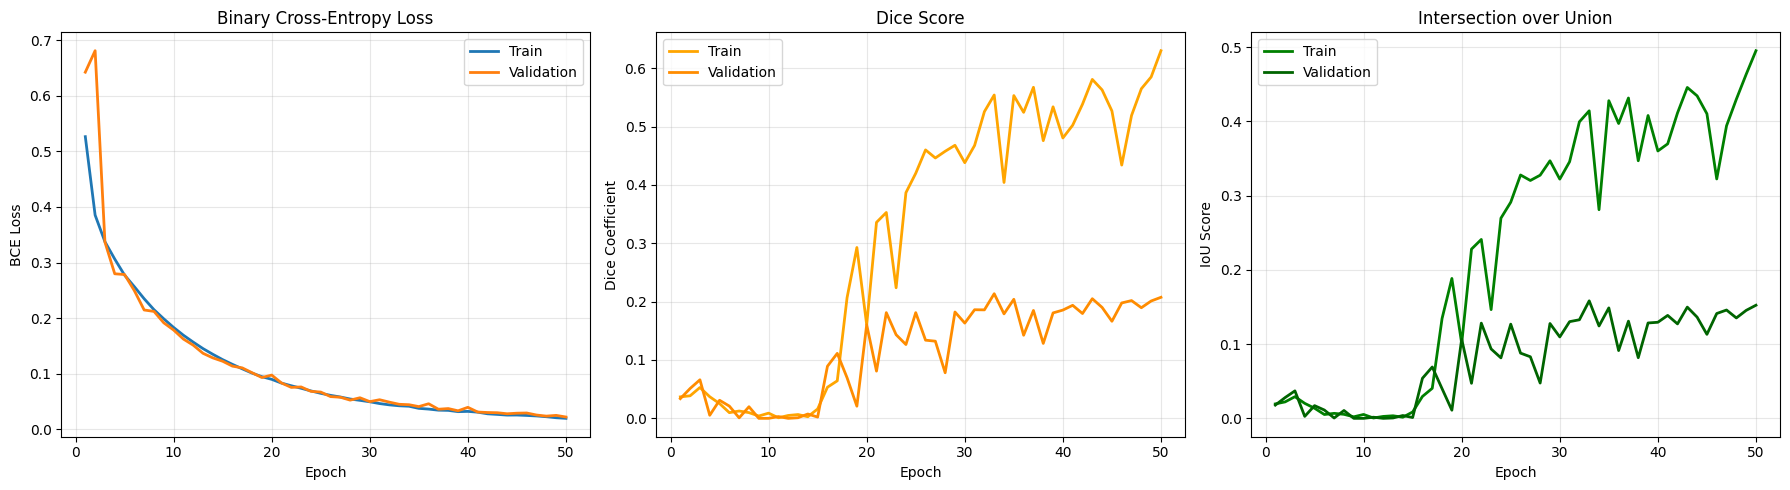

In [6]:
def plot_training_curves(history):
    """Plot training and validation curves"""
    epochs = range(1, len(history['train_loss']) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # BCE Loss
    axes[0].plot(epochs, history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('BCE Loss')
    axes[0].set_title('Binary Cross-Entropy Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Dice Score
    axes[1].plot(epochs, history['train_dice'], label='Train', linewidth=2, color='orange')
    axes[1].plot(epochs, history['val_dice'], label='Validation', linewidth=2, color='darkorange')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Dice Coefficient')
    axes[1].set_title('Dice Score')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[2].plot(epochs, history['train_iou'], label='Train', linewidth=2, color='green')
    axes[2].plot(epochs, history['val_iou'], label='Validation', linewidth=2, color='darkgreen')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('IoU Score')
    axes[2].set_title('Intersection over Union')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history)

## 7. Classification from Segmentation Masks


🔍 EVALUATING ON TEST SET
Classification based on: Segmentation probabilities [0, 1] from sigmoid
Metrics computed: Dice & IoU for each sample



Evaluating Test: 100%|██████████| 12/12 [00:01<00:00,  6.46it/s]



=======================🎯 SEGMENTATION METRICS ========================
  Dice Coefficient: 0.4975
  IoU Score: 0.3311
  BCE Loss: 0.0456
  Pixel Accuracy: 0.9943
  Sensitivity (Recall): 0.7735
  Specificity: 0.9952
  Precision: 0.3666

===========🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ===========
  Accuracy: 0.4457
  Precision: 0.3544
  Recall: 1.0000
  F1-Score: 0.5234

  Per-Sample Metrics:
    Mean Dice: 0.1814
    Mean IoU: 0.1421

  Average Dice by Classification:
    True Positives (TP): 0.5960
    True Negatives (TN): 0.0000
    False Positives (FP): 0.0000
    False Negatives (FN): 0.0000

=========================📊 CONFUSION MATRIX ==========================


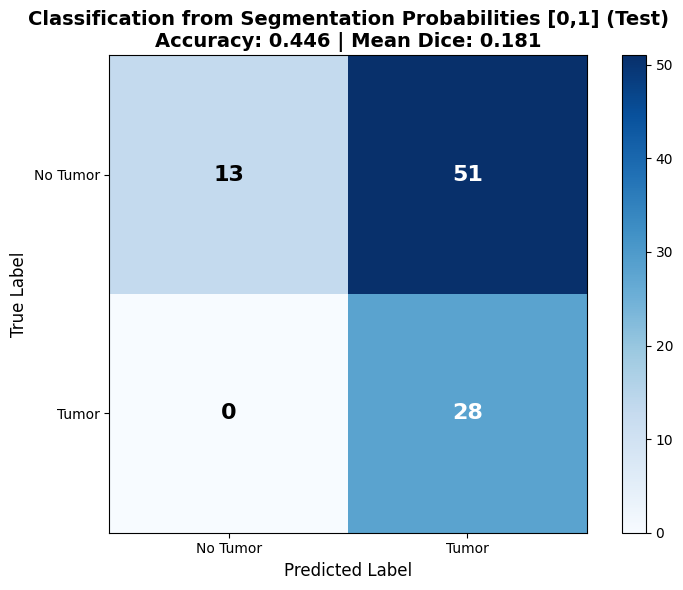

In [14]:
def classify_from_mask(mask_pred, mask_true, threshold=0.5, epsilon=1e-7):
    """
    Classify image based on segmentation probabilities [0, 1].
    
    Classification logic:
    - If ANY pixel >= threshold (0.5) in predicted mask → Tumor (1)
    - If NO pixels >= threshold → Healthy (0)
    
    Also computes Dice and IoU metrics for analysis.
    
    Args:
        mask_pred: Predicted segmentation probabilities [0, 1] (after sigmoid)
        mask_true: Ground truth mask [0, 1]
        threshold: Threshold for binarizing masks (default 0.5)
        epsilon: Small constant for numerical stability
    
    Returns:
        predicted_class: 1 if any tumor pixel detected, 0 otherwise
        dice_score: Dice coefficient for this prediction
        iou_score: IoU for this prediction
    """
    # Binarize masks at threshold 0.5
    # mask_pred already contains probabilities [0,1] from sigmoid
    # Pixels with prob ≥ 0.5 become 1, pixels < 0.5 become 0
    pred_binary = (mask_pred > threshold).float()
    true_binary = (mask_true > threshold).float()
    
    # Compute Dice coefficient
    intersection = (pred_binary * true_binary).sum().item()
    pred_sum = pred_binary.sum().item()  # Count of pixels with value 1
    true_sum = true_binary.sum().item()
    
    dice = (2.0 * intersection) / (pred_sum + true_sum + epsilon)
    
    # Compute IoU
    union = pred_sum + true_sum - intersection
    iou = intersection / (union + epsilon)
    
    # Classification: If ANY pixel == 1 (after thresholding) → Tumor
    # If ALL pixels == 0 → Healthy
    predicted_class = 1 if pred_sum > 0 else 0
    
    return predicted_class, dice, iou


def evaluate_segmentation_and_classification(model, dataloader, split_name="Test"):
    """
    Evaluate both segmentation and classification.
    Classification is derived from segmentation quality (Dice/IoU scores).
    """
    model.eval()
    
    # Segmentation metrics
    all_seg_preds = []
    all_seg_true = []
    
    # Classification metrics
    all_clf_preds = []
    all_clf_true = []
    
    # Per-sample metrics for analysis
    all_dice_scores = []
    all_iou_scores = []
    
    print("\n" + "="*70)
    print(f"🔍 EVALUATING ON {split_name.upper()} SET")
    print("="*70)
    print("Classification based on: Segmentation probabilities [0, 1] from sigmoid")
    print("Metrics computed: Dice & IoU for each sample\n")
    
    with torch.no_grad():
        for images, masks, clf_labels in tqdm(dataloader, desc=f"Evaluating {split_name}"):
            images = images.to(device)
            
            # Stage 1: Segmentation
            seg_logits = model(images)        # Raw outputs: [-∞, +∞]
            seg_probs = torch.sigmoid(seg_logits)  # Probabilities: [0, 1]
            
            # Store segmentation predictions
            all_seg_preds.append(seg_probs.cpu())
            all_seg_true.append(masks.cpu())
            
            # Stage 2: Classification from segmentation quality
            for i in range(seg_probs.size(0)):
                # Compute classification using Dice/IoU
                pred_label, dice, iou = classify_from_mask(
                    seg_probs[i].cpu(), 
                    masks[i].cpu()
                )
                true_label = clf_labels[i].item()
                
                all_clf_preds.append(pred_label)
                all_clf_true.append(true_label)
                all_dice_scores.append(dice)
                all_iou_scores.append(iou)
    
    # Concatenate segmentation results
    seg_preds = torch.cat(all_seg_preds, dim=0)
    seg_true = torch.cat(all_seg_true, dim=0)
    
    # ===============================
    # SEGMENTATION METRICS
    # ===============================
    pred_binary = (seg_preds > 0.5).float()
    true_binary = (seg_true > 0.5).float()
    
    pred_flat = pred_binary.view(-1)
    true_flat = true_binary.view(-1)
    
    TP = (pred_flat * true_flat).sum().item()
    FP = (pred_flat * (1 - true_flat)).sum().item()
    FN = ((1 - pred_flat) * true_flat).sum().item()
    TN = ((1 - pred_flat) * (1 - true_flat)).sum().item()
    
    epsilon = 1e-7
    
    iou = TP / (TP + FP + FN + epsilon)
    dice = (2 * TP) / (2 * TP + FP + FN + epsilon)
    pixel_acc = (TP + TN) / (TP + TN + FP + FN + epsilon)
    sensitivity = TP / (TP + FN + epsilon)
    specificity = TN / (TN + FP + epsilon)
    precision = TP / (TP + FP + epsilon)
    
    # Compute BCE loss
    bce_loss = seg_criterion(torch.logit(seg_preds.clamp(epsilon, 1-epsilon)), seg_true).item()
    
    seg_metrics = {
        'IoU': iou,
        'Dice': dice,
        'BCE_Loss': bce_loss,
        'Pixel_Accuracy': pixel_acc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision
    }
    
    print("\n" + "🎯 SEGMENTATION METRICS ".center(70, "="))
    print(f"  Dice Coefficient: {seg_metrics['Dice']:.4f}")
    print(f"  IoU Score: {seg_metrics['IoU']:.4f}")
    print(f"  BCE Loss: {seg_metrics['BCE_Loss']:.4f}")
    print(f"  Pixel Accuracy: {seg_metrics['Pixel_Accuracy']:.4f}")
    print(f"  Sensitivity (Recall): {seg_metrics['Sensitivity']:.4f}")
    print(f"  Specificity: {seg_metrics['Specificity']:.4f}")
    print(f"  Precision: {seg_metrics['Precision']:.4f}")
    
    # ===============================
    # CLASSIFICATION METRICS
    # ===============================
    all_clf_preds = np.array(all_clf_preds)
    all_clf_true = np.array(all_clf_true)
    all_dice_scores = np.array(all_dice_scores)
    all_iou_scores = np.array(all_iou_scores)
    
    # Confusion matrix
    TP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 1))
    TN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 0))
    FP_clf = np.sum((all_clf_preds == 1) & (all_clf_true == 0))
    FN_clf = np.sum((all_clf_preds == 0) & (all_clf_true == 1))
    
    cm = np.array([[TN_clf, FP_clf], [FN_clf, TP_clf]])
    
    accuracy = (TP_clf + TN_clf) / (TP_clf + TN_clf + FP_clf + FN_clf + epsilon)
    precision_clf = TP_clf / (TP_clf + FP_clf + epsilon)
    recall_clf = TP_clf / (TP_clf + FN_clf + epsilon)
    f1_score = 2 * (precision_clf * recall_clf) / (precision_clf + recall_clf + epsilon)
    
    # Average Dice/IoU for each classification outcome
    tp_indices = (all_clf_preds == 1) & (all_clf_true == 1)
    tn_indices = (all_clf_preds == 0) & (all_clf_true == 0)
    fp_indices = (all_clf_preds == 1) & (all_clf_true == 0)
    fn_indices = (all_clf_preds == 0) & (all_clf_true == 1)
    
    avg_dice_tp = all_dice_scores[tp_indices].mean() if tp_indices.sum() > 0 else 0
    avg_dice_tn = all_dice_scores[tn_indices].mean() if tn_indices.sum() > 0 else 0
    avg_dice_fp = all_dice_scores[fp_indices].mean() if fp_indices.sum() > 0 else 0
    avg_dice_fn = all_dice_scores[fn_indices].mean() if fn_indices.sum() > 0 else 0
    
    clf_metrics = {
        'Confusion_Matrix': cm,
        'Accuracy': accuracy,
        'Precision': precision_clf,
        'Recall': recall_clf,
        'F1_Score': f1_score,
        'Avg_Dice_TP': avg_dice_tp,
        'Avg_Dice_TN': avg_dice_tn,
        'Avg_Dice_FP': avg_dice_fp,
        'Avg_Dice_FN': avg_dice_fn,
        'Mean_Dice': all_dice_scores.mean(),
        'Mean_IoU': all_iou_scores.mean()
    }
    
    print("\n" + "🎯 CLASSIFICATION METRICS (from Seg Probs [0,1]) ".center(70, "="))
    print(f"  Accuracy: {clf_metrics['Accuracy']:.4f}")
    print(f"  Precision: {clf_metrics['Precision']:.4f}")
    print(f"  Recall: {clf_metrics['Recall']:.4f}")
    print(f"  F1-Score: {clf_metrics['F1_Score']:.4f}")
    print(f"\n  Per-Sample Metrics:")
    print(f"    Mean Dice: {clf_metrics['Mean_Dice']:.4f}")
    print(f"    Mean IoU: {clf_metrics['Mean_IoU']:.4f}")
    print(f"\n  Average Dice by Classification:")
    print(f"    True Positives (TP): {avg_dice_tp:.4f}")
    print(f"    True Negatives (TN): {avg_dice_tn:.4f}")
    print(f"    False Positives (FP): {avg_dice_fp:.4f}")
    print(f"    False Negatives (FN): {avg_dice_fn:.4f}")
    
    # Plot Confusion Matrix
    print("\n" + "📊 CONFUSION MATRIX ".center(70, "="))
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, cmap='Blues', interpolation='nearest')
    
    plt.colorbar(im, ax=ax)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['No Tumor', 'Tumor'])
    ax.set_yticklabels(['No Tumor', 'Tumor'])
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, int(cm[i, j]),
                          ha="center", va="center", 
                          color="white" if cm[i, j] > cm.max()/2 else "black",
                          fontsize=16, fontweight='bold')
    
    ax.set_title(f"Classification from Segmentation Probabilities [0,1] ({split_name})\nAccuracy: {clf_metrics['Accuracy']:.3f} | Mean Dice: {clf_metrics['Mean_Dice']:.3f}", 
                 fontsize=14, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*70 + "\n")
    
    return seg_metrics, clf_metrics


# Evaluate on Test Set
test_seg_metrics, test_clf_metrics = evaluate_segmentation_and_classification(
    unet_model, test_loader, split_name="Test"
)